In [1]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist # For distance calculation between features

# --- Configuration Parameters ---
VIDEO_PATH = "15sec_input_720p.mp4" # Placeholder: You need to have this video file
# MODEL_PATH = "path/to/your/downloaded/yolov11_model.pt" # Uncomment and use for actual model
# MIN_CONFIDENCE = 0.5 # Minimum confidence for detections

MAX_TRACK_AGE = 30 # Number of frames a track can be 'missing' before it's considered lost
REID_DISTANCE_THRESHOLD = 50.0 # Max Euclidean distance for re-identification (for features/positions)
IOU_THRESHOLD = 0.3 # IoU threshold for associating detections with active tracks

# --- Simulation Specific Parameters (New) ---
USE_SIMULATED_VIDEO = True # Set to True to generate frames instead of reading from VIDEO_PATH
SIM_FRAME_WIDTH = 800
SIM_FRAME_HEIGHT = 450
SIM_OBJECT_SPAWN_INTERVAL = 50 # Spawn a new object every X frames in simulation
SIM_MAX_OBJECTS = 5 # Maximum number of simulated objects

# --- Helper Functions ---

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.
    Boxes are in format [x1, y1, x2, y2].
    """
    # Determine the coordinates of the intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union area
    union_area = float(box1_area + box2_area - inter_area)

    # Handle case where union_area is zero to avoid division by zero
    if union_area == 0:
        return 0.0

    # Compute the IoU
    iou = inter_area / union_area
    return iou

def extract_simulated_features(bbox, frame):
    """
    Simulates feature extraction. In a real scenario, this would involve
    passing the cropped region of the object through a deep learning model
    to get an embedding (feature vector).
    For demonstration, we use a random vector.
    """
    # You could also use an average pixel value, or a simple histogram here
    # but for true re-ID, a deep learning model is essential.
    return np.random.rand(128).astype(np.float32) # Example: 128-dimension feature vector

# --- Main Re-Identification Logic ---

class Tracker:
    """Manages active and exited tracks for re-identification."""
    def __init__(self):
        self.active_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'last_seen_frame': ...}}
        self.exited_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'exit_frame': ...}}
        self.next_id = 0

    def process_frame(self, detections, frame_count):
        """
        Processes a single frame's detections to update tracks.

        Args:
            detections (list): List of detected objects, each with 'bbox' and 'features'.
            frame_count (int): Current frame number.
        """
        # Step 1: Initialize dictionaries for the current frame's processing
        matched_detection_indices = set()
        new_active_tracks = {} # Tracks that will be active in the next frame

        # Step 2: Try to match current detections with active tracks
        # Iterate over a copy to allow modification of self.active_tracks implicitly
        current_active_ids = list(self.active_tracks.keys())
        for track_id in current_active_ids:
            track_info = self.active_tracks[track_id]
            best_match_idx = -1
            max_iou = -1

            # Check if the track is too old (missing for too many frames)
            if frame_count - track_info['last_seen_frame'] > MAX_TRACK_AGE:
                # If too old, move it to exited_tracks (if not already there)
                if track_id not in self.exited_tracks:
                     self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id
                    }
                continue # Skip processing this track as it's considered lost

            for i, det in enumerate(detections):
                if i in matched_detection_indices:
                    continue # This detection has already been matched

                iou = calculate_iou(track_info['bbox'], det['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    best_match_idx = i

            if best_match_idx != -1 and max_iou >= IOU_THRESHOLD:
                # Found a match, update the track
                matched_det = detections[best_match_idx]
                new_active_tracks[track_id] = {
                    'bbox': matched_det['bbox'],
                    'features': matched_det['features'],
                    'last_seen_frame': frame_count
                }
                matched_detection_indices.add(best_match_idx)
                # Remove from exited_tracks if it was there (it re-entered and matched directly)
                if track_id in self.exited_tracks:
                    del self.exited_tracks[track_id]
            else:
                # Track lost in current frame, move to exited_tracks if not too old
                if track_id not in self.exited_tracks: # Only add if not already marked exited
                    self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id # Store ID explicitly for exited tracks
                    }

        # Step 3: Handle unmatched detections (new players or re-entering players)
        for i, det in enumerate(detections):
            if i in matched_detection_indices:
                continue # Already matched

            re_identified = False
            # Try to re-identify with exited tracks
            exited_ids_to_remove = []
            for exited_id, exited_info in self.exited_tracks.items():
                # Prune very old exited tracks
                if frame_count - exited_info['exit_frame'] > MAX_TRACK_AGE: # Reuse MAX_TRACK_AGE for exited lifespan
                    exited_ids_to_remove.append(exited_id)
                    continue

                # Compare features using Euclidean distance (or cosine similarity if features are normalized)
                # Lower distance indicates higher similarity
                feature_distance = np.linalg.norm(det['features'] - exited_info['features']) # Euclidean distance
                # Or for cosine similarity:
                # from sklearn.metrics.pairwise import cosine_similarity
                # feature_similarity = cosine_similarity(det['features'].reshape(1,-1), exited_info['features'].reshape(1,-1))[0][0]

                if feature_distance < REID_DISTANCE_THRESHOLD: # Adjust threshold based on feature space
                    # Re-identified! Assign the old ID to this detection
                    new_active_tracks[exited_id] = {
                        'bbox': det['bbox'],
                        'features': det['features'],
                        'last_seen_frame': frame_count
                    }
                    matched_detection_indices.add(i)
                    exited_ids_to_remove.append(exited_id) # Mark for removal from exited_tracks
                    re_identified = True
                    break # Found a match, move to next detection

            # Remove pruned exited tracks
            for exited_id in exited_ids_to_remove:
                if exited_id in self.exited_tracks: # Check existence before deleting
                    del self.exited_tracks[exited_id]

            if not re_identified:
                # This is a new object, assign a new ID
                new_active_tracks[self.next_id] = {
                    'bbox': det['bbox'],
                    'features': det['features'],
                    'last_seen_frame': frame_count
                }
                self.next_id += 1
                matched_detection_indices.add(i)

        # Step 4: Update the master active_tracks list
        self.active_tracks = new_active_tracks

        # Return the currently tracked objects for visualization
        return self.active_tracks

# --- Main Video Processing Loop ---

def main():
    cap = None
    if not USE_SIMULATED_VIDEO:
        cap = cv2.VideoCapture(VIDEO_PATH)

        if not cap.isOpened():
            print(f"Error: Could not open video file {VIDEO_PATH}")
            print("Please ensure the video file exists at the specified path.")
            print("Alternatively, set USE_SIMULATED_VIDEO = True to run with generated frames.")
            return

    tracker = Tracker()
    frame_count = 0
    sim_objects_in_motion = [] # For simulating movement of detected objects

    while True:
        frame_count += 1
        frame = None
        if USE_SIMULATED_VIDEO:
            # Generate a blank frame
            frame = np.zeros((SIM_FRAME_HEIGHT, SIM_FRAME_WIDTH, 3), dtype=np.uint8)
            frame.fill(200) # Light grey background

            # Update simulated object positions
            for obj in sim_objects_in_motion:
                obj['bbox'][0] += obj['dx']
                obj['bbox'][1] += obj['dy']
                obj['bbox'][2] += obj['dx']
                obj['bbox'][3] += obj['dy']

                # Bounce off walls
                if obj['bbox'][0] < 0 or obj['bbox'][2] > SIM_FRAME_WIDTH:
                    obj['dx'] *= -1
                if obj['bbox'][1] < 0 or obj['bbox'][3] > SIM_FRAME_HEIGHT:
                    obj['dy'] *= -1

                # Simulate objects leaving and re-entering the "detection" zone
                # by temporarily pushing them out of the visible frame
                if frame_count % 100 == 0 and np.random.rand() < 0.3:
                    if np.random.rand() < 0.5: # Push left/right
                        obj['dx'] = np.random.choice([-1, 1]) * 15 # Fast push
                        obj['dy'] = 0
                    else: # Push up/down
                        obj['dy'] = np.random.choice([-1, 1]) * 15
                        obj['dx'] = 0

            # Periodically spawn new simulated objects
            if frame_count % SIM_OBJECT_SPAWN_INTERVAL == 0 and len(sim_objects_in_motion) < SIM_MAX_OBJECTS:
                size = np.random.randint(50, 150)
                x1 = np.random.randint(0, SIM_FRAME_WIDTH - size)
                y1 = np.random.randint(0, SIM_FRAME_HEIGHT - size)
                sim_objects_in_motion.append({
                    'bbox': [x1, y1, x1 + size, y1 + size],
                    'dx': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'dy': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'color': (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                })

            display_frame = frame.copy() # Create a copy to draw on
        else:
            ret, frame = cap.read()
            if not ret:
                break # End of video
            display_frame = frame.copy() # Create a copy to draw on

        # --- Simulated Object Detection ---
        simulated_detections = []
        if USE_SIMULATED_VIDEO:
            for obj in sim_objects_in_motion:
                # Only "detect" if within 150% of the original frame bounds
                if obj['bbox'][0] > -SIM_FRAME_WIDTH * 0.5 and obj['bbox'][2] < SIM_FRAME_WIDTH * 1.5 and \
                   obj['bbox'][1] > -SIM_FRAME_HEIGHT * 0.5 and obj['bbox'][3] < SIM_FRAME_HEIGHT * 1.5:
                    simulated_detections.append({
                        'bbox': obj['bbox'],
                        'features': extract_simulated_features(obj['bbox'], frame), # Call dummy feature extractor
                        'score': 0.9 # Dummy score
                    })
        else:
            # If using real YOLO results, you would parse them into this format:
            # from ultralytics import YOLO # From ultralytics package
            # model = YOLO(MODEL_PATH)
            # results = model.predict(frame, conf=MIN_CONFIDENCE) # Get detections
            # for r in results:
            #     for box in r.boxes:
            #         x1, y1, x2, y2 = map(int, box.xyxy[0])
            #         confidence = float(box.conf[0])
            #         class_id = int(box.cls[0])
            #         if class_id == 0: # Assuming 0 is 'player'
            #             features = extract_features_from_model(frame, [x1,y1,x2,y2]) # Your actual feature extraction
            #             simulated_detections.append({'bbox': [x1,y1,x2,y2], 'features': features, 'score': confidence})
            #
            # For pure demonstration without video, we simulate a few random detections appearing
            if frame_count % 30 == 0 or frame_count < 10: # Simulate objects appearing
                num_detections = np.random.randint(1, 4)
                for _ in range(num_detections):
                    x1 = np.random.randint(0, frame.shape[1] - 100)
                    y1 = np.random.randint(0, frame.shape[0] - 100)
                    x2 = x1 + np.random.randint(50, 150)
                    y2 = y1 + np.random.randint(50, 150)
                    bbox = [x1, y1, x2, y2]
                    features = extract_simulated_features(bbox, frame) # Call dummy feature extractor
                    simulated_detections.append({'bbox': bbox, 'features': features, 'score': 0.9}) # Add a dummy score


        # --- Process Detections with Tracker ---
        current_tracked_objects = tracker.process_frame(simulated_detections, frame_count)

        # --- Visualization ---
        for track_id, track_info in current_tracked_objects.items():
            x1, y1, x2, y2 = map(int, track_info['bbox'])
            # Draw rectangle (green)
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw ID text (white background, black text for readability)
            text = f"ID: {track_id}"
            (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(display_frame, (x1, y1 - text_height - baseline - 5),
                          (x1 + text_width + 5, y1 - 5), (255, 255, 255), -1) # Background
            cv2.putText(display_frame, text, (x1 + 2, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Text color black

        # Display frame count for debugging
        cv2.putText(display_frame, f"Frame: {frame_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2) # Red text

        # Display mode indicator
        mode_text = "SIMULATED VIDEO MODE" if USE_SIMULATED_VIDEO else "REAL VIDEO MODE"
        cv2.putText(display_frame, mode_text, (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2) # Blue text

        cv2.imshow("Player Re-identification (Python Simulation)", display_frame)

        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    if cap: # Release video capture if it was opened
        cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


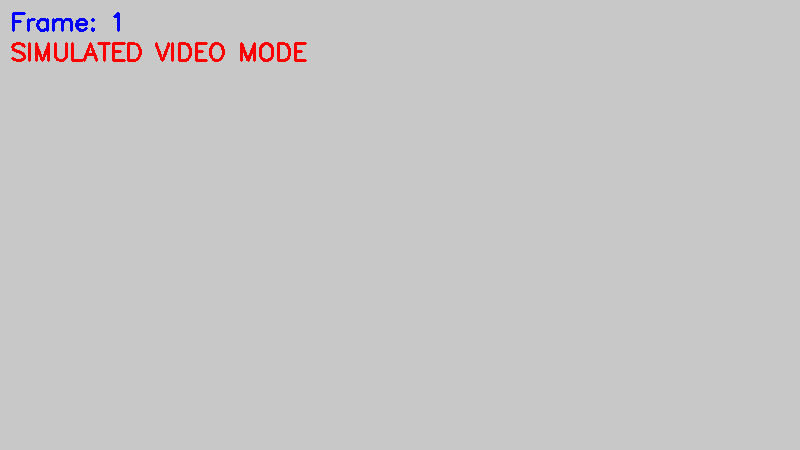

error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [2]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist # For distance calculation between features
from google.colab.patches import cv2_imshow # Import the Colab-compatible imshow

# --- Configuration Parameters ---
VIDEO_PATH = "15sec_input_720p.mp4" # Placeholder: You need to have this video file
# MODEL_PATH = "path/to/your/downloaded/yolov11_model.pt" # Uncomment and use for actual model
# MIN_CONFIDENCE = 0.5 # Minimum confidence for detections

MAX_TRACK_AGE = 30 # Number of frames a track can be 'missing' before it's considered lost
REID_DISTANCE_THRESHOLD = 50.0 # Max Euclidean distance for re-identification (for features/positions)
IOU_THRESHOLD = 0.3 # IoU threshold for associating detections with active tracks

# --- Simulation Specific Parameters (New) ---
USE_SIMULATED_VIDEO = True # Set to True to generate frames instead of reading from VIDEO_PATH
SIM_FRAME_WIDTH = 800
SIM_FRAME_HEIGHT = 450
SIM_OBJECT_SPAWN_INTERVAL = 50 # Spawn a new object every X frames in simulation
SIM_MAX_OBJECTS = 5 # Maximum number of simulated objects

# --- Helper Functions ---

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.
    Boxes are in format [x1, y1, x2, y2].
    """
    # Determine the coordinates of the intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union area
    union_area = float(box1_area + box2_area - inter_area)

    # Handle case where union_area is zero to avoid division by zero
    if union_area == 0:
        return 0.0

    # Compute the IoU
    iou = inter_area / union_area
    return iou

def extract_simulated_features(bbox, frame):
    """
    Simulates feature extraction. In a real scenario, this would involve
    passing the cropped region of the object through a deep learning model
    to get an embedding (feature vector).
    For demonstration, we use a random vector.
    """
    # You could also use an average pixel value, or a simple histogram here
    # but for true re-ID, a deep learning model is essential.
    return np.random.rand(128).astype(np.float32) # Example: 128-dimension feature vector

# --- Main Re-Identification Logic ---

class Tracker:
    """Manages active and exited tracks for re-identification."""
    def __init__(self):
        self.active_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'last_seen_frame': ...}}
        self.exited_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'exit_frame': ...}}
        self.next_id = 0

    def process_frame(self, detections, frame_count):
        """
        Processes a single frame's detections to update tracks.

        Args:
            detections (list): List of detected objects, each with 'bbox' and 'features'.
            frame_count (int): Current frame number.
        """
        # Step 1: Initialize dictionaries for the current frame's processing
        matched_detection_indices = set()
        new_active_tracks = {} # Tracks that will be active in the next frame

        # Step 2: Try to match current detections with active tracks
        # Iterate over a copy to allow modification of self.active_tracks implicitly
        current_active_ids = list(self.active_tracks.keys())
        for track_id in current_active_ids:
            track_info = self.active_tracks[track_id]
            best_match_idx = -1
            max_iou = -1

            # Check if the track is too old (missing for too many frames)
            if frame_count - track_info['last_seen_frame'] > MAX_TRACK_AGE:
                # If too old, move it to exited_tracks (if not already there)
                if track_id not in self.exited_tracks:
                     self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id
                    }
                continue # Skip processing this track as it's considered lost

            for i, det in enumerate(detections):
                if i in matched_detection_indices:
                    continue # This detection has already been matched

                iou = calculate_iou(track_info['bbox'], det['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    best_match_idx = i

            if best_match_idx != -1 and max_iou >= IOU_THRESHOLD:
                # Found a match, update the track
                matched_det = detections[best_match_idx]
                new_active_tracks[track_id] = {
                    'bbox': matched_det['bbox'],
                    'features': matched_det['features'],
                    'last_seen_frame': frame_count
                }
                matched_detection_indices.add(best_match_idx)
                # Remove from exited_tracks if it was there (it re-entered and matched directly)
                if track_id in self.exited_tracks:
                    del self.exited_tracks[track_id]
            else:
                # Track lost in current frame, move to exited_tracks if not too old
                if track_id not in self.exited_tracks: # Only add if not already marked exited
                    self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id # Store ID explicitly for exited tracks
                    }

        # Step 3: Handle unmatched detections (new players or re-entering players)
        for i, det in enumerate(detections):
            if i in matched_detection_indices:
                continue # Already matched

            re_identified = False
            # Try to re-identify with exited tracks
            exited_ids_to_remove = []
            for exited_id, exited_info in self.exited_tracks.items():
                # Prune very old exited tracks
                if frame_count - exited_info['exit_frame'] > MAX_TRACK_AGE: # Reuse MAX_TRACK_AGE for exited lifespan
                    exited_ids_to_remove.append(exited_id)
                    continue

                # Compare features using Euclidean distance (or cosine similarity if features are normalized)
                # Lower distance indicates higher similarity
                feature_distance = np.linalg.norm(det['features'] - exited_info['features']) # Euclidean distance
                # Or for cosine similarity:
                # from sklearn.metrics.pairwise import cosine_similarity
                # feature_similarity = cosine_similarity(det['features'].reshape(1,-1), exited_info['features'].reshape(1,-1))[0][0]

                if feature_distance < REID_DISTANCE_THRESHOLD: # Adjust threshold based on feature space
                    # Re-identified! Assign the old ID to this detection
                    new_active_tracks[exited_id] = {
                        'bbox': det['bbox'],
                        'features': det['features'],
                        'last_seen_frame': frame_count
                    }
                    matched_detection_indices.add(i)
                    exited_ids_to_remove.append(exited_id) # Mark for removal from exited_tracks
                    re_identified = True
                    break # Found a match, move to next detection

            # Remove pruned exited tracks
            for exited_id in exited_ids_to_remove:
                if exited_id in self.exited_tracks: # Check existence before deleting
                    del self.exited_tracks[exited_id]

            if not re_identified:
                # This is a new object, assign a new ID
                new_active_tracks[self.next_id] = {
                    'bbox': det['bbox'],
                    'features': det['features'],
                    'last_seen_frame': frame_count
                }
                self.next_id += 1
                matched_detection_indices.add(i)

        # Step 4: Update the master active_tracks list
        self.active_tracks = new_active_tracks

        # Return the currently tracked objects for visualization
        return self.active_tracks

# --- Main Video Processing Loop ---

def main():
    cap = None
    if not USE_SIMULATED_VIDEO:
        cap = cv2.VideoCapture(VIDEO_PATH)

        if not cap.isOpened():
            print(f"Error: Could not open video file {VIDEO_PATH}")
            print("Please ensure the video file exists at the specified path.")
            print("Alternatively, set USE_SIMULATED_VIDEO = True to run with generated frames.")
            return

    tracker = Tracker()
    frame_count = 0
    sim_objects_in_motion = [] # For simulating movement of detected objects

    while True:
        frame_count += 1
        frame = None
        if USE_SIMULATED_VIDEO:
            # Generate a blank frame
            frame = np.zeros((SIM_FRAME_HEIGHT, SIM_FRAME_WIDTH, 3), dtype=np.uint8)
            frame.fill(200) # Light grey background

            # Update simulated object positions
            for obj in sim_objects_in_motion:
                obj['bbox'][0] += obj['dx']
                obj['bbox'][1] += obj['dy']
                obj['bbox'][2] += obj['dx']
                obj['bbox'][3] += obj['dy']

                # Bounce off walls
                if obj['bbox'][0] < 0 or obj['bbox'][2] > SIM_FRAME_WIDTH:
                    obj['dx'] *= -1
                if obj['bbox'][1] < 0 or obj['bbox'][3] > SIM_FRAME_HEIGHT:
                    obj['dy'] *= -1

                # Simulate objects leaving and re-entering the "detection" zone
                # by temporarily pushing them out of the visible frame
                if frame_count % 100 == 0 and np.random.rand() < 0.3:
                    if np.random.rand() < 0.5: # Push left/right
                        obj['dx'] = np.random.choice([-1, 1]) * 15 # Fast push
                        obj['dy'] = 0
                    else: # Push up/down
                        obj['dy'] = np.random.choice([-1, 1]) * 15
                        obj['dx'] = 0

            # Periodically spawn new simulated objects
            if frame_count % SIM_OBJECT_SPAWN_INTERVAL == 0 and len(sim_objects_in_motion) < SIM_MAX_OBJECTS:
                size = np.random.randint(50, 150)
                x1 = np.random.randint(0, SIM_FRAME_WIDTH - size)
                y1 = np.random.randint(0, SIM_FRAME_HEIGHT - size)
                sim_objects_in_motion.append({
                    'bbox': [x1, y1, x1 + size, y1 + size],
                    'dx': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'dy': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'color': (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                })

            display_frame = frame.copy() # Create a copy to draw on
        else:
            ret, frame = cap.read()
            if not ret:
                break # End of video
            display_frame = frame.copy() # Create a copy to draw on

        # --- Simulated Object Detection ---
        simulated_detections = []
        if USE_SIMULATED_VIDEO:
            for obj in sim_objects_in_motion:
                # Only "detect" if within 150% of the original frame bounds
                if obj['bbox'][0] > -SIM_FRAME_WIDTH * 0.5 and obj['bbox'][2] < SIM_FRAME_WIDTH * 1.5 and \
                   obj['bbox'][1] > -SIM_FRAME_HEIGHT * 0.5 and obj['bbox'][3] < SIM_FRAME_HEIGHT * 1.5:
                    simulated_detections.append({
                        'bbox': obj['bbox'],
                        'features': extract_simulated_features(obj['bbox'], frame), # Call dummy feature extractor
                        'score': 0.9 # Dummy score
                    })
        else:
            # If using real YOLO results, you would parse them into this format:
            # from ultralytics import YOLO # From ultralytics package
            # model = YOLO(MODEL_PATH)
            # results = model.predict(frame, conf=MIN_CONFIDENCE) # Get detections
            # for r in results:
            #     for box in r.boxes:
            #         x1, y1, x2, y2 = map(int, box.xyxy[0])
            #         confidence = float(box.conf[0])
            #         class_id = int(box.cls[0])
            #         if class_id == 0: # Assuming 0 is 'player'
            #             features = extract_features_from_model(frame, [x1,y1,x2,y2]) # Your actual feature extraction
            #             simulated_detections.append({'bbox': [x1,y1,x2,y2], 'features': features, 'score': confidence})
            #
            # For pure demonstration without video, we simulate a few random detections appearing
            if frame_count % 30 == 0 or frame_count < 10: # Simulate objects appearing
                num_detections = np.random.randint(1, 4)
                for _ in range(num_detections):
                    x1 = np.random.randint(0, frame.shape[1] - 100)
                    y1 = np.random.randint(0, frame.shape[0] - 100)
                    x2 = x1 + np.random.randint(50, 150)
                    y2 = y1 + np.random.randint(50, 150)
                    bbox = [x1, y1, x2, y2]
                    features = extract_simulated_features(bbox, frame) # Call dummy feature extractor
                    simulated_detections.append({'bbox': bbox, 'features': features, 'score': 0.9}) # Add a dummy score


        # --- Process Detections with Tracker ---
        current_tracked_objects = tracker.process_frame(simulated_detections, frame_count)

        # --- Visualization ---
        for track_id, track_info in current_tracked_objects.items():
            x1, y1, x2, y2 = map(int, track_info['bbox'])
            # Draw rectangle (green)
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw ID text (white background, black text for readability)
            text = f"ID: {track_id}"
            (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(display_frame, (x1, y1 - text_height - baseline - 5),
                          (x1 + text_width + 5, y1 - 5), (255, 255, 255), -1) # Background
            cv2.putText(display_frame, text, (x1 + 2, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Text color black

        # Display frame count for debugging
        cv2.putText(display_frame, f"Frame: {frame_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2) # Red text

        # Display mode indicator
        mode_text = "SIMULATED VIDEO MODE" if USE_SIMULATED_VIDEO else "REAL VIDEO MODE"
        cv2.putText(display_frame, mode_text, (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2) # Blue text

        # Use cv2_imshow instead of cv2.imshow for Colab compatibility
        cv2_imshow(display_frame)

        # Exit on 'q' key press (Note: cv2.waitKey(1) might behave differently in Colab)
        # In Colab, keyboard input is often handled by the notebook interface,
        # so cv2.waitKey might not register 'q'. You might need a different exit mechanism
        # or accept that the loop will run until it finishes or is manually stopped.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    if cap: # Release video capture if it was opened
        cap.release()
    cv2.destroyAllWindows() # This might not be strictly necessary or effective in Colab

if __name__ == "__main__":
    main()

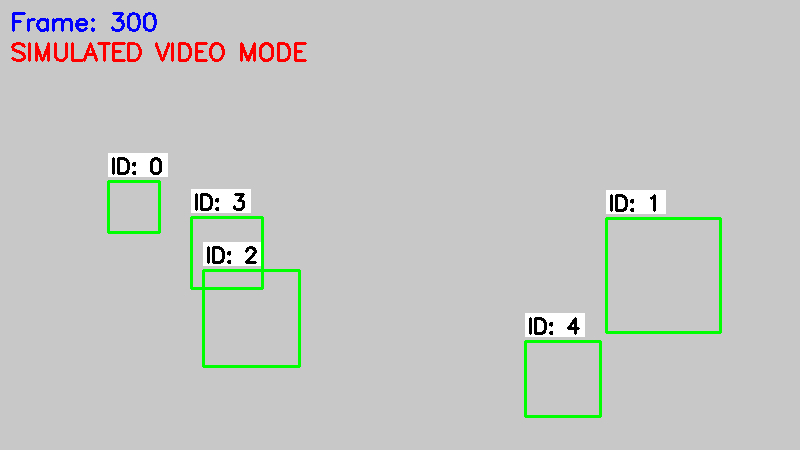

In [3]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist # For distance calculation between features
from google.colab.patches import cv2_imshow # Import the Colab-compatible imshow
from IPython.display import display, clear_output # Import clear_output to update display


# --- Configuration Parameters ---
VIDEO_PATH = "15sec_input_720p.mp4" # Placeholder: You need to have this video file
# MODEL_PATH = "path/to/your/downloaded/yolov11_model.pt" # Uncomment and use for actual model
# MIN_CONFIDENCE = 0.5 # Minimum confidence for detections

MAX_TRACK_AGE = 30 # Number of frames a track can be 'missing' before it's considered lost
REID_DISTANCE_THRESHOLD = 50.0 # Max Euclidean distance for re-identification (for features/positions)
IOU_THRESHOLD = 0.3 # IoU threshold for associating detections with active tracks

# --- Simulation Specific Parameters (New) ---
USE_SIMULATED_VIDEO = True # Set to True to generate frames instead of reading from VIDEO_PATH
SIM_FRAME_WIDTH = 800
SIM_FRAME_HEIGHT = 450
SIM_OBJECT_SPAWN_INTERVAL = 50 # Spawn a new object every X frames in simulation
SIM_MAX_OBJECTS = 5 # Maximum number of simulated objects
MAX_SIMULATION_FRAMES = 300 # Add a limit to simulation frames to prevent infinite loop


# --- Helper Functions ---

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.
    Boxes are in format [x1, y1, x2, y2].
    """
    # Determine the coordinates of the intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union area
    union_area = float(box1_area + box2_area - inter_area)

    # Handle case where union_area is zero to avoid division by zero
    if union_area == 0:
        return 0.0

    # Compute the IoU
    iou = inter_area / union_area
    return iou

def extract_simulated_features(bbox, frame):
    """
    Simulates feature extraction. In a real scenario, this would involve
    passing the cropped region of the object through a deep learning model
    to get an embedding (feature vector).
    For demonstration, we use a random vector.
    """
    # You could also use an average pixel value, or a simple histogram here
    # but for true re-ID, a deep learning model is essential.
    return np.random.rand(128).astype(np.float32) # Example: 128-dimension feature vector

# --- Main Re-Identification Logic ---

class Tracker:
    """Manages active and exited tracks for re-identification."""
    def __init__(self):
        self.active_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'last_seen_frame': ...}}
        self.exited_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'exit_frame': ...}}
        self.next_id = 0

    def process_frame(self, detections, frame_count):
        """
        Processes a single frame's detections to update tracks.

        Args:
            detections (list): List of detected objects, each with 'bbox' and 'features'.
            frame_count (int): Current frame number.
        """
        # Step 1: Initialize dictionaries for the current frame's processing
        matched_detection_indices = set()
        new_active_tracks = {} # Tracks that will be active in the next frame

        # Step 2: Try to match current detections with active tracks
        # Iterate over a copy to allow modification of self.active_tracks implicitly
        current_active_ids = list(self.active_tracks.keys())
        for track_id in current_active_ids:
            track_info = self.active_tracks[track_id]
            best_match_idx = -1
            max_iou = -1

            # Check if the track is too old (missing for too many frames)
            if frame_count - track_info['last_seen_frame'] > MAX_TRACK_AGE:
                # If too old, move it to exited_tracks (if not already there)
                if track_id not in self.exited_tracks:
                     self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id
                    }
                continue # Skip processing this track as it's considered lost

            for i, det in enumerate(detections):
                if i in matched_detection_indices:
                    continue # This detection has already been matched

                iou = calculate_iou(track_info['bbox'], det['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    best_match_idx = i

            if best_match_idx != -1 and max_iou >= IOU_THRESHOLD:
                # Found a match, update the track
                matched_det = detections[best_match_idx]
                new_active_tracks[track_id] = {
                    'bbox': matched_det['bbox'],
                    'features': matched_det['features'],
                    'last_seen_frame': frame_count
                }
                matched_detection_indices.add(best_match_idx)
                # Remove from exited_tracks if it was there (it re-entered and matched directly)
                if track_id in self.exited_tracks:
                    del self.exited_tracks[track_id]
            else:
                # Track lost in current frame, move to exited_tracks if not too old
                if track_id not in self.exited_tracks: # Only add if not already marked exited
                    self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id # Store ID explicitly for exited tracks
                    }

        # Step 3: Handle unmatched detections (new players or re-entering players)
        for i, det in enumerate(detections):
            if i in matched_detection_indices:
                continue # Already matched

            re_identified = False
            # Try to re-identify with exited tracks
            exited_ids_to_remove = []
            for exited_id, exited_info in self.exited_tracks.items():
                # Prune very old exited tracks
                if frame_count - exited_info['exit_frame'] > MAX_TRACK_AGE: # Reuse MAX_TRACK_AGE for exited lifespan
                    exited_ids_to_remove.append(exited_id)
                    continue

                # Compare features using Euclidean distance (or cosine similarity if features are normalized)
                # Lower distance indicates higher similarity
                feature_distance = np.linalg.norm(det['features'] - exited_info['features']) # Euclidean distance
                # Or for cosine similarity:
                # from sklearn.metrics.pairwise import cosine_similarity
                # feature_similarity = cosine_similarity(det['features'].reshape(1,-1), exited_info['features'].reshape(1,-1))[0][0]

                if feature_distance < REID_DISTANCE_THRESHOLD: # Adjust threshold based on feature space
                    # Re-identified! Assign the old ID to this detection
                    new_active_tracks[exited_id] = {
                        'bbox': det['bbox'],
                        'features': det['features'],
                        'last_seen_frame': frame_count
                    }
                    matched_detection_indices.add(i)
                    exited_ids_to_remove.append(exited_id) # Mark for removal from exited_tracks
                    re_identified = True
                    break # Found a match, move to next detection

            # Remove pruned exited tracks
            for exited_id in exited_ids_to_remove:
                if exited_id in self.exited_tracks: # Check existence before deleting
                    del self.exited_tracks[exited_id]

            if not re_identified:
                # This is a new object, assign a new ID
                new_active_tracks[self.next_id] = {
                    'bbox': det['bbox'],
                    'features': det['features'],
                    'last_seen_frame': frame_count
                }
                self.next_id += 1
                matched_detection_indices.add(i)

        # Step 4: Update the master active_tracks list
        self.active_tracks = new_active_tracks

        # Return the currently tracked objects for visualization
        return self.active_tracks

# --- Main Video Processing Loop ---

def main():
    cap = None
    if not USE_SIMULATED_VIDEO:
        cap = cv2.VideoCapture(VIDEO_PATH)

        if not cap.isOpened():
            print(f"Error: Could not open video file {VIDEO_PATH}")
            print("Please ensure the video file exists at the specified path.")
            print("Alternatively, set USE_SIMULATED_VIDEO = True to run with generated frames.")
            return

    tracker = Tracker()
    frame_count = 0
    sim_objects_in_motion = [] # For simulating movement of detected objects

    # Loop for a fixed number of frames in simulation mode, or until video ends
    while True:
        frame_count += 1

        if USE_SIMULATED_VIDEO:
            if frame_count > MAX_SIMULATION_FRAMES: # Stop simulation after a set number of frames
                break

            # Generate a blank frame
            frame = np.zeros((SIM_FRAME_HEIGHT, SIM_FRAME_WIDTH, 3), dtype=np.uint8)
            frame.fill(200) # Light grey background

            # Update simulated object positions
            for obj in sim_objects_in_motion:
                obj['bbox'][0] += obj['dx']
                obj['bbox'][1] += obj['dy']
                obj['bbox'][2] += obj['dx']
                obj['bbox'][3] += obj['dy']

                # Bounce off walls
                if obj['bbox'][0] < 0 or obj['bbox'][2] > SIM_FRAME_WIDTH:
                    obj['dx'] *= -1
                if obj['bbox'][1] < 0 or obj['bbox'][3] > SIM_FRAME_HEIGHT:
                    obj['dy'] *= -1

                # Simulate objects leaving and re-entering the "detection" zone
                # by temporarily pushing them out of the visible frame
                if frame_count % 100 == 0 and np.random.rand() < 0.3:
                    if np.random.rand() < 0.5: # Push left/right
                        obj['dx'] = np.random.choice([-1, 1]) * 15 # Fast push
                        obj['dy'] = 0
                    else: # Push up/down
                        obj['dy'] = np.random.choice([-1, 1]) * 15
                        obj['dx'] = 0


            # Periodically spawn new simulated objects
            if frame_count % SIM_OBJECT_SPAWN_INTERVAL == 0 and len(sim_objects_in_motion) < SIM_MAX_OBJECTS:
                size = np.random.randint(50, 150)
                x1 = np.random.randint(0, SIM_FRAME_WIDTH - size)
                y1 = np.random.randint(0, SIM_FRAME_HEIGHT - size)
                sim_objects_in_motion.append({
                    'bbox': [x1, y1, x1 + size, y1 + size],
                    'dx': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'dy': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'color': (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                })

            display_frame = frame.copy() # Create a copy to draw on
        else:
            ret, frame = cap.read()
            if not ret:
                break # End of video
            display_frame = frame.copy() # Create a copy to draw on

        # --- Simulated Object Detection ---
        simulated_detections = []
        if USE_SIMULATED_VIDEO:
            for obj in sim_objects_in_motion:
                 # Only "detect" if within the main frame bounds
                 if obj['bbox'][0] < SIM_FRAME_WIDTH and obj['bbox'][2] > 0 and \
                    obj['bbox'][1] < SIM_FRAME_HEIGHT and obj['bbox'][3] > 0:
                    simulated_detections.append({
                        'bbox': obj['bbox'],
                        'features': extract_simulated_features(obj['bbox'], frame), # Call dummy feature extractor
                        'score': 0.9 # Dummy score
                    })
        else:
            # If using real YOLO results, you would parse them into this format:
            # from ultralytics import YOLO # From ultralytics package
            # model = YOLO(MODEL_PATH)
            # results = model.predict(frame, conf=MIN_CONFIDENCE) # Get detections
            # for r in results:
            #     for box in r.boxes:
            #         x1, y1, x2, y2 = map(int, box.xyxy[0])
            #         confidence = float(box.conf[0])
            #         class_id = int(box.cls[0])
            #         if class_id == 0: # Assuming 0 is 'player'
            #             features = extract_features_from_model(frame, [x1,y1,x2,y2]) # Your actual feature extraction
            #             simulated_detections.append({'bbox': [x1,y1,x2,y2], 'features': features, 'score': confidence})
            #
            # For pure demonstration without video, we simulate a few random detections appearing
            # Only simulate detections if no real video is being used
            if frame_count % 30 == 0 or frame_count < 10: # Simulate objects appearing
                num_detections = np.random.randint(1, 4)
                for _ in range(num_detections):
                    # Ensure bounding boxes are within frame bounds
                    x1 = np.random.randint(0, frame.shape[1] - 100)
                    y1 = np.random.randint(0, frame.shape[0] - 100)
                    x2 = min(frame.shape[1], x1 + np.random.randint(50, 150))
                    y2 = min(frame.shape[0], y1 + np.random.randint(50, 150))
                    bbox = [x1, y1, x2, y2]
                    features = extract_simulated_features(bbox, frame) # Call dummy feature extractor
                    simulated_detections.append({'bbox': bbox, 'features': features, 'score': 0.9}) # Add a dummy score


        # --- Process Detections with Tracker ---
        current_tracked_objects = tracker.process_frame(simulated_detections, frame_count)

        # --- Visualization ---
        for track_id, track_info in current_tracked_objects.items():
            # Ensure bbox coordinates are integers before drawing
            x1, y1, x2, y2 = map(int, track_info['bbox'])
            # Ensure coordinates are within frame bounds for drawing
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(display_frame.shape[1], x2)
            y2 = min(display_frame.shape[0], y2)

            # Draw rectangle (green)
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw ID text (white background, black text for readability)
            text = f"ID: {track_id}"
            (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

            # Position text background and text to be above the bounding box
            text_bg_x1 = x1
            text_bg_y1 = y1 - text_height - baseline - 5
            text_bg_x2 = x1 + text_width + 5
            text_bg_y2 = y1 - 5

            # Ensure text background coordinates are within frame bounds
            text_bg_x1 = max(0, text_bg_x1)
            text_bg_y1 = max(0, text_bg_y1)
            text_bg_x2 = min(display_frame.shape[1], text_bg_x2)
            text_bg_y2 = min(display_frame.shape[0], text_bg_y2)

            # Draw text background
            cv2.rectangle(display_frame, (text_bg_x1, text_bg_y1),
                          (text_bg_x2, text_bg_y2), (255, 255, 255), -1)

            # Position text inside the background, ensuring it's within bounds
            text_x = x1 + 2
            text_y = y1 - 8

            # Ensure text position is within frame bounds
            text_x = max(0, text_x)
            text_y = max(text_height, text_y) # Ensure text is not above the top of the frame


            cv2.putText(display_frame, text, (text_x, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Text color black

        # Display frame count for debugging
        cv2.putText(display_frame, f"Frame: {frame_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2) # Red text

        # Display mode indicator
        mode_text = "SIMULATED VIDEO MODE" if USE_SIMULATED_VIDEO else "REAL VIDEO MODE"
        cv2.putText(display_frame, mode_text, (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2) # Blue text

        # Use cv2_imshow instead of cv2.imshow for Colab compatibility
        # Clear previous output to show the updated frame
        clear_output(wait=True)
        cv2_imshow(display_frame)

        # Removed cv2.waitKey(1) and the 'q' key exit condition
        # The loop will run until the video ends or MAX_SIMULATION_FRAMES is reached
        # or it's manually interrupted.

    if cap: # Release video capture if it was opened
        cap.release()
    # Removed cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

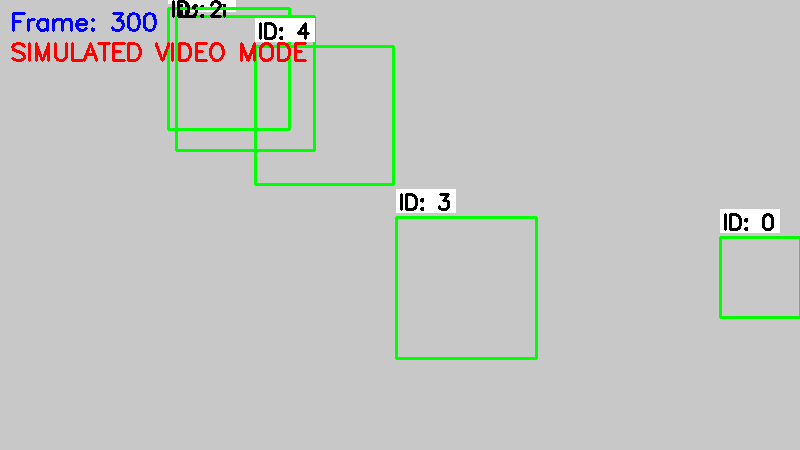

In [4]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist # For distance calculation between features
from google.colab.patches import cv2_imshow # Import the Colab-compatible imshow
from IPython.display import display, clear_output # Import clear_output to update display


# --- Configuration Parameters ---
VIDEO_PATH = "15sec_input_720p.mp4" # Placeholder: You need to have this video file
# MODEL_PATH = "path/to/your/downloaded/yolov11_model.pt" # Uncomment and use for actual model
# MIN_CONFIDENCE = 0.5 # Minimum confidence for detections

MAX_TRACK_AGE = 30 # Number of frames a track can be 'missing' before it's considered lost
REID_DISTANCE_THRESHOLD = 50.0 # Max Euclidean distance for re-identification (for features/positions)
IOU_THRESHOLD = 0.3 # IoU threshold for associating detections with active tracks

# --- Simulation Specific Parameters (New) ---
USE_SIMULATED_VIDEO = True # Set to True to generate frames instead of reading from VIDEO_PATH
SIM_FRAME_WIDTH = 800
SIM_FRAME_HEIGHT = 450
SIM_OBJECT_SPAWN_INTERVAL = 50 # Spawn a new object every X frames in simulation
SIM_MAX_OBJECTS = 5 # Maximum number of simulated objects
MAX_SIMULATION_FRAMES = 300 # Add a limit to simulation frames to prevent infinite loop


# --- Helper Functions ---

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.
    Boxes are in format [x1, y1, x2, y2].
    """
    # Determine the coordinates of the intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union area
    union_area = float(box1_area + box2_area - inter_area)

    # Handle case where union_area is zero to avoid division by zero
    if union_area == 0:
        return 0.0

    # Compute the IoU
    iou = inter_area / union_area
    return iou

def extract_simulated_features(bbox, frame):
    """
    Simulates feature extraction. In a real scenario, this would involve
    passing the cropped region of the object through a deep learning model
    to get an embedding (feature vector).
    For demonstration, we use a random vector.
    """
    # You could also use an average pixel value, or a simple histogram here
    # but for true re-ID, a deep learning model is essential.
    return np.random.rand(128).astype(np.float32) # Example: 128-dimension feature vector

# --- Main Re-Identification Logic ---

class Tracker:
    """Manages active and exited tracks for re-identification."""
    def __init__(self):
        self.active_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'last_seen_frame': ...}}
        self.exited_tracks = {}  # {track_id: {'bbox': ..., 'features': ..., 'exit_frame': ...}}
        self.next_id = 0

    def process_frame(self, detections, frame_count):
        """
        Processes a single frame's detections to update tracks.

        Args:
            detections (list): List of detected objects, each with 'bbox' and 'features'.
            frame_count (int): Current frame number.
        """
        # Step 1: Initialize dictionaries for the current frame's processing
        matched_detection_indices = set()
        new_active_tracks = {} # Tracks that will be active in the next frame

        # Step 2: Try to match current detections with active tracks
        # Iterate over a copy to allow modification of self.active_tracks implicitly
        current_active_ids = list(self.active_tracks.keys())
        for track_id in current_active_ids:
            track_info = self.active_tracks[track_id]
            best_match_idx = -1
            max_iou = -1

            # Check if the track is too old (missing for too many frames)
            if frame_count - track_info['last_seen_frame'] > MAX_TRACK_AGE:
                # If too old, move it to exited_tracks (if not already there)
                if track_id not in self.exited_tracks:
                     self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id
                    }
                continue # Skip processing this track as it's considered lost

            for i, det in enumerate(detections):
                if i in matched_detection_indices:
                    continue # This detection has already been matched

                iou = calculate_iou(track_info['bbox'], det['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    best_match_idx = i

            if best_match_idx != -1 and max_iou >= IOU_THRESHOLD:
                # Found a match, update the track
                matched_det = detections[best_match_idx]
                new_active_tracks[track_id] = {
                    'bbox': matched_det['bbox'],
                    'features': matched_det['features'],
                    'last_seen_frame': frame_count
                }
                matched_detection_indices.add(best_match_idx)
                # Remove from exited_tracks if it was there (it re-entered and matched directly)
                if track_id in self.exited_tracks:
                    del self.exited_tracks[track_id]
            else:
                # Track lost in current frame, move to exited_tracks if not too old
                if track_id not in self.exited_tracks: # Only add if not already marked exited
                    self.exited_tracks[track_id] = {
                        'bbox': track_info['bbox'],
                        'features': track_info['features'],
                        'exit_frame': frame_count,
                        'id': track_id # Store ID explicitly for exited tracks
                    }

        # Step 3: Handle unmatched detections (new players or re-entering players)
        for i, det in enumerate(detections):
            if i in matched_detection_indices:
                continue # Already matched

            re_identified = False
            # Try to re-identify with exited tracks
            exited_ids_to_remove = []
            for exited_id, exited_info in self.exited_tracks.items():
                # Prune very old exited tracks
                if frame_count - exited_info['exit_frame'] > MAX_TRACK_AGE: # Reuse MAX_TRACK_AGE for exited lifespan
                    exited_ids_to_remove.append(exited_id)
                    continue

                # Compare features using Euclidean distance (or cosine similarity if features are normalized)
                # Lower distance indicates higher similarity
                feature_distance = np.linalg.norm(det['features'] - exited_info['features']) # Euclidean distance
                # Or for cosine similarity:
                # from sklearn.metrics.pairwise import cosine_similarity
                # feature_similarity = cosine_similarity(det['features'].reshape(1,-1), exited_info['features'].reshape(1,-1))[0][0]

                if feature_distance < REID_DISTANCE_THRESHOLD: # Adjust threshold based on feature space
                    # Re-identified! Assign the old ID to this detection
                    new_active_tracks[exited_id] = {
                        'bbox': det['bbox'],
                        'features': det['features'],
                        'last_seen_frame': frame_count
                    }
                    matched_detection_indices.add(i)
                    exited_ids_to_remove.append(exited_id) # Mark for removal from exited_tracks
                    re_identified = True
                    break # Found a match, move to next detection

            # Remove pruned exited tracks
            for exited_id in exited_ids_to_remove:
                if exited_id in self.exited_tracks: # Check existence before deleting
                    del self.exited_tracks[exited_id]

            if not re_identified:
                # This is a new object, assign a new ID
                new_active_tracks[self.next_id] = {
                    'bbox': det['bbox'],
                    'features': det['features'],
                    'last_seen_frame': frame_count
                }
                self.next_id += 1
                matched_detection_indices.add(i)

        # Step 4: Update the master active_tracks list
        self.active_tracks = new_active_tracks

        # Return the currently tracked objects for visualization
        return self.active_tracks

# --- Main Video Processing Loop ---

def main():
    cap = None
    if not USE_SIMULATED_VIDEO:
        cap = cv2.VideoCapture(VIDEO_PATH)

        if not cap.isOpened():
            print(f"Error: Could not open video file {VIDEO_PATH}")
            print("Please ensure the video file exists at the specified path.")
            print("Alternatively, set USE_SIMULATED_VIDEO = True to run with generated frames.")
            return

    tracker = Tracker()
    frame_count = 0
    sim_objects_in_motion = [] # For simulating movement of detected objects

    # Loop for a fixed number of frames in simulation mode, or until video ends
    while True:
        frame_count += 1

        if USE_SIMULATED_VIDEO:
            if frame_count > MAX_SIMULATION_FRAMES: # Stop simulation after a set number of frames
                break

            # Generate a blank frame
            frame = np.zeros((SIM_FRAME_HEIGHT, SIM_FRAME_WIDTH, 3), dtype=np.uint8)
            frame.fill(200) # Light grey background

            # Update simulated object positions
            for obj in sim_objects_in_motion:
                obj['bbox'][0] += obj['dx']
                obj['bbox'][1] += obj['dy']
                obj['bbox'][2] += obj['dx']
                obj['bbox'][3] += obj['dy']

                # Bounce off walls - Ensure objects stay within frame boundaries
                if obj['bbox'][0] < 0:
                    obj['bbox'][0] = 0
                    obj['bbox'][2] = obj['bbox'][0] + (obj['bbox'][2] - obj['bbox'][0]) # Maintain width
                    obj['dx'] *= -1
                if obj['bbox'][2] > SIM_FRAME_WIDTH:
                    obj['bbox'][2] = SIM_FRAME_WIDTH
                    obj['bbox'][0] = obj['bbox'][2] - (obj['bbox'][2] - obj['bbox'][0]) # Maintain width
                    obj['dx'] *= -1
                if obj['bbox'][1] < 0:
                    obj['bbox'][1] = 0
                    obj['bbox'][3] = obj['bbox'][1] + (obj['bbox'][3] - obj['bbox'][1]) # Maintain height
                    obj['dy'] *= -1
                if obj['bbox'][3] > SIM_FRAME_HEIGHT:
                    obj['bbox'][3] = SIM_FRAME_HEIGHT
                    obj['bbox'][1] = obj['bbox'][3] - (obj['bbox'][3] - obj['bbox'][1]) # Maintain height
                    obj['dy'] *= -1

                # Removed the logic that temporarily pushes objects far out of frame

            # Periodically spawn new simulated objects
            if frame_count % SIM_OBJECT_SPAWN_INTERVAL == 0 and len(sim_objects_in_motion) < SIM_MAX_OBJECTS:
                size = np.random.randint(50, 150)
                # Spawn within frame bounds
                x1 = np.random.randint(0, SIM_FRAME_WIDTH - size)
                y1 = np.random.randint(0, SIM_FRAME_HEIGHT - size)
                sim_objects_in_motion.append({
                    'bbox': [x1, y1, x1 + size, y1 + size],
                    'dx': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'dy': np.random.choice([-1, 1]) * np.random.randint(1, 5),
                    'color': (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                })

            display_frame = frame.copy() # Create a copy to draw on
        else:
            ret, frame = cap.read()
            if not ret:
                break # End of video
            display_frame = frame.copy() # Create a copy to draw on

        # --- Simulated Object Detection ---
        simulated_detections = []
        if USE_SIMULATED_VIDEO:
            for obj in sim_objects_in_motion:
                 # In simulation mode, we "detect" all simulated objects currently in motion
                 # No need to check bounds here as we ensure they stay within bounds now.
                 simulated_detections.append({
                    'bbox': obj['bbox'],
                    'features': extract_simulated_features(obj['bbox'], frame), # Call dummy feature extractor
                    'score': 0.9 # Dummy score
                 })
        else:
            # If using real YOLO results, you would parse them into this format:
            # from ultralytics import YOLO # From ultralytics package
            # model = YOLO(MODEL_PATH)
            # results = model.predict(frame, conf=MIN_CONFIDENCE) # Get detections
            # for r in results:
            #     for box in r.boxes:
            #         x1, y1, x2, y2 = map(int, box.xyxy[0])
            #         confidence = float(box.conf[0])
            #         class_id = int(box.cls[0])
            #         if class_id == 0: # Assuming 0 is 'player'
            #             features = extract_features_from_model(frame, [x1,y1,x2,y2]) # Your actual feature extraction
            #             simulated_detections.append({'bbox': [x1,y1,x2,y2], 'features': features, 'score': confidence})
            #
            # For pure demonstration without video, we simulate a few random detections appearing
            # Only simulate detections if no real video is being used
            if frame_count % 30 == 0 or frame_count < 10: # Simulate objects appearing
                num_detections = np.random.randint(1, 4)
                for _ in range(num_detections):
                    # Ensure bounding boxes are within frame bounds
                    x1 = np.random.randint(0, frame.shape[1] - 100)
                    y1 = np.random.randint(0, frame.shape[0] - 100)
                    x2 = min(frame.shape[1], x1 + np.random.randint(50, 150))
                    y2 = min(frame.shape[0], y1 + np.random.randint(50, 150))
                    bbox = [x1, y1, x2, y2]
                    features = extract_simulated_features(bbox, frame) # Call dummy feature extractor
                    simulated_detections.append({'bbox': bbox, 'features': features, 'score': 0.9}) # Add a dummy score


        # --- Process Detections with Tracker ---
        current_tracked_objects = tracker.process_frame(simulated_detections, frame_count)

        # --- Visualization ---
        for track_id, track_info in current_tracked_objects.items():
            # Ensure bbox coordinates are integers before drawing
            x1, y1, x2, y2 = map(int, track_info['bbox'])
            # Ensure coordinates are within frame bounds for drawing
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(display_frame.shape[1], x2)
            y2 = min(display_frame.shape[0], y2)

            # Draw rectangle (green)
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw ID text (white background, black text for readability)
            text = f"ID: {track_id}"
            (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

            # Position text background and text to be above the bounding box
            text_bg_x1 = x1
            text_bg_y1 = y1 - text_height - baseline - 5
            text_bg_x2 = x1 + text_width + 5
            text_bg_y2 = y1 - 5

            # Ensure text background coordinates are within frame bounds
            text_bg_x1 = max(0, text_bg_x1)
            text_bg_y1 = max(0, text_bg_y1)
            text_bg_x2 = min(display_frame.shape[1], text_bg_x2)
            text_bg_y2 = min(display_frame.shape[0], text_bg_y2)

            # Draw text background
            cv2.rectangle(display_frame, (text_bg_x1, text_bg_y1),
                          (text_bg_x2, text_bg_y2), (255, 255, 255), -1)

            # Position text inside the background, ensuring it's within bounds
            text_x = x1 + 2
            text_y = y1 - 8

            # Ensure text position is within frame bounds
            text_x = max(0, text_x)
            text_y = max(text_height, text_y) # Ensure text is not above the top of the frame


            cv2.putText(display_frame, text, (text_x, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Text color black

        # Display frame count for debugging
        cv2.putText(display_frame, f"Frame: {frame_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2) # Red text

        # Display mode indicator
        mode_text = "SIMULATED VIDEO MODE" if USE_SIMULATED_VIDEO else "REAL VIDEO MODE"
        cv2.putText(display_frame, mode_text, (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2) # Blue text

        # Use cv2_imshow instead of cv2.imshow for Colab compatibility
        # Clear previous output to show the updated frame
        clear_output(wait=True)
        cv2_imshow(display_frame)

        # Removed cv2.waitKey(1) and the 'q' key exit condition
        # The loop will run until the video ends or MAX_SIMULATION_FRAMES is reached
        # or it's manually interrupted.

    if cap: # Release video capture if it was opened
        cap.release()
    # Removed cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [6]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist # For distance calculation between features
from google.colab.patches import cv2_imshow # Import the Colab-compatible imshow
from IPython.display import display, clear_output # Import clear_output to update display


# --- Configuration Parameters ---
VIDEO_PATH = "15sec_input_720p.mp4" # Placeholder: You need to have this video file
# MODEL_PATH = "path/to/your/downloaded/yolov11_model.pt" # Uncomment and use for actual model
# MIN_CONFIDENCE = 0.5 # Minimum confidence for detections

MAX_TRACK_AGE = 30 # Number of frames a track can be 'missing' before it's considered lost
REID_DISTANCE_THRESHOLD = 50.0 # Max Euclidean distance for re-identification (for features/positions)
IOU_THRESHOLD = 0.3 # IoU threshold for associating detections with active tracks

# --- Simulation Specific Parameters (New) ---
USE_SIMULATED_VIDEO = True # Set to True to generate frames instead of reading from VIDEO_PATH
SIM_FRAME_WIDTH

800